In [1]:
import numpy
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("dataset/train_data.csv")

In [49]:
df.YEAR.value_counts()

2017/18    6088
2018/19    5861
Name: YEAR, dtype: int64

In [3]:
df.columns

Index(['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'POSTCODE', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'Borough', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'NTA', 'New Georeferenced Column'],
      dtype='object')

In [4]:
def find_closest_cluster(point, clusters):
    if np.sum(np.isnan(point)) > 0:
        return -1, 0
    dist = np.sqrt(np.sum((clusters - point)**2, axis=1))
    ind = np.argmin(dist)
    min_dist = np.min(dist)
    return ind, min_dist

In [5]:
clusters = pd.read_csv("clusters.csv")
clusters = clusters.set_index("labels")

In [6]:
def df_info(df):
    #print(df.info())
    return df

In [7]:
def select_columns(df, columns=[]):
    """
    Selects columns from `columns`
    """
    return df.loc[:,columns]

In [8]:
def encode_easement(df):
    df.EASEMENT = df.EASEMENT.apply(lambda x: int(len(str(x)) == 1))
    return df

In [9]:
def fix_stories(df):
    df.STORIES.fillna(0, inplace=True)
    return df

In [10]:
def calculate_dist(df):
    cl = []
    dist = []
    for point in zip(df.Latitude, df.Longitude):
        point = np.array(point)
        ind, mdis = find_closest_cluster(point, clusters=clusters)
        cl += [ind]
        dist += [mdis]
    df["cluster"] = cl
    df["dist"] = dist
    return df

In [11]:
#df["NTA_VAL"] = df.NTA.map(df.groupby("NTA").mean().FULLVAL)
#df["BORO_VAL"] = df.BORO.map(df.groupby("BORO").mean().FULLVAL)
#df["BLOCK_VAL"] = df.BLOCK.map(df.groupby("BLOCK").mean().FULLVAL)

In [12]:
result = df.pipe(df_info) \
  .pipe(select_columns, columns=
          [
           "BORO",
           "EASEMENT",
           "TAXCLASS",
           "LTFRONT",
           "Latitude",
           "Longitude",
           "LTDEPTH",
           "AVTOT",
           "EXLAND",
           "EXTOT",
           "STORIES",
           "FULLVAL", # Y
           #"NTA",
           #"NTA_VAL",
           #"BORO_VAL",
           #"BLOCK_VAL"
          ]) \
  .pipe(fix_stories) \
  .pipe(encode_easement) \
  .pipe(calculate_dist)

In [13]:
result = result.drop(columns=["EASEMENT", "Latitude", "Longitude", "EXLAND", "EXTOT", "STORIES", "cluster"])

In [14]:
result.columns

Index(['BORO', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'AVTOT', 'FULLVAL', 'dist'], dtype='object')

In [15]:
from pycaret.regression import *

In [16]:
smol = result[result.AVTOT < 0.1e6]

In [29]:
9029/len(df)

0.7556280860323039

In [17]:
s = setup(smol, target = 'FULLVAL')

,Description,Value
0,session_id,7355
1,Target,FULLVAL
2,Original Data,"(9029, 7)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6320, 19)"


In [18]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,93094.1741,75383648982.7576,271242.7697,0.7553,0.6200,0.1926,0.1080
et,Extra Trees Regressor,91386.0764,76599806666.2232,273314.0074,0.7504,0.5170,0.1458,0.0770
lightgbm,Light Gradient Boosting Machine,104643.0747,77115145532.6760,274473.2051,0.7485,1.6850,0.4117,0.0180
gbr,Gradient Boosting Regressor,111548.7716,78286022050.4812,276978.5629,0.7446,1.7461,0.6156,0.0650
lasso,Lasso Regression,195565.9995,143561033431.6360,375339.8190,0.5351,2.1751,4.5866,0.1370
lr,Linear Regression,195610.2070,143581494455.3931,375367.4111,0.5350,2.1754,4.5843,0.1680
llar,Lasso Least Angle Regression,195652.6010,143682380460.4834,375495.2021,0.5347,2.1766,4.5774,0.0060
br,Bayesian Ridge,194591.9918,143725522225.7116,375536.5804,0.5347,2.1750,4.7584,0.0060
lar,Least Angle Regression,195764.5682,143810790229.5227,375669.0200,0.5343,2.1755,4.5857,0.0060
ridge,Ridge Regression,194258.8460,145028806696.6704,377222.5680,0.5305,2.1779,5.1645,0.1380


In [19]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [27]:
tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,98458.0470,106075061638.6920,325691.6665,0.7221,0.2335,0.1257
1,94836.7883,94215728923.4190,306945.8078,0.7838,0.3847,0.1704
2,91004.8385,69485614509.3479,263601.2415,0.7782,0.4295,0.1711
3,88493.1403,52978308070.4491,230170.1720,0.7770,0.6473,0.1350
4,106503.9676,86590484017.9769,294262.6106,0.7252,0.6503,0.1497
5,85878.2648,62075212829.2062,249148.9772,0.7791,0.5270,0.1258
6,70626.7612,34908445588.1277,186838.0197,0.8393,0.3008,0.2865
7,93321.5012,65556610315.8997,256040.2514,0.7232,0.6320,0.1312
8,122007.5960,125441843241.5322,354177.7001,0.6875,0.5394,0.1697


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=220, n_jobs=-1, oob_score=False,
                      random_state=7355, verbose=0, warm_start=False)

In [40]:
new_data = smol.copy()

In [41]:
pred = predict_model(best, data = new_data.drop(columns="FULLVAL"))

In [42]:
pred

,BORO,TAXCLASS,LTFRONT,LTDEPTH,AVTOT,dist,Label
2,1,2,0,0,78002,0.005493,173247.78
3,1,2,0,0,83048,0.008646,184391.89
16,1,4,0,0,1480,0.008087,2850.78
17,1,2,0,0,50033,0.003792,112071.33
18,1,2,0,0,93615,0.005306,208254.21
...,...,...,...,...,...,...,...
11944,5,1,25,100,21814,0.025690,409320.00
11945,5,1A,0,0,11851,0.024776,236807.87
11946,5,1,45,100,16663,0.024179,317150.00
11947,5,1,62,50,25164,0.003269,468180.00


In [43]:
df.FULLVAL

0        3463000
1         247784
2         173338
3         184550
4         559937
          ...   
11944     407000
11945     244285
11946     298000
11947     459000
11948     557000
Name: FULLVAL, Length: 11949, dtype: int64

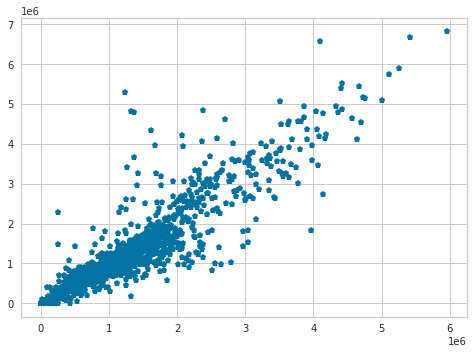

In [45]:
plt.plot(pred.Label, smol.FULLVAL, 'p')